In [1]:
from pathlib import Path
import pandas as pd
import json
import pyarrow as pa
import matplotlib

import sklearn
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import jaccard_score
from scipy.spatial.distance import squareform
from scipy.spatial.distance import pdist
import numpy as np

In [2]:
pd.set_option('display.max_colwidth', None)
pd.options.display.max_columns = None

In [3]:
#MOA
data_dir_moa = Path('C:/Users/ArulSeetharaman/Desktop/AdverseDrugReactions_SignalPrediction/Data/parquet/mechanismOfAction/')
moa_full_df = pd.concat(
    pd.read_parquet(parquet_file)
    for parquet_file in data_dir_moa.glob('*.parquet')
)

#AE
data_dir = Path('C:/Users/ArulSeetharaman/Desktop/AdverseDrugReactions_SignalPrediction/Data/parquet/fda/significantAdverseDrugReactions/')
ae_full_df = pd.concat(
    pd.read_parquet(parquet_file)
    for parquet_file in data_dir.glob('*.parquet')
)

#TARGETS-PATHWAY
data_dir_targets = Path('C:/Users/ArulSeetharaman/Desktop/AdverseDrugReactions_SignalPrediction/Data/parquet/targets/')
targets_full_df = pd.concat(
    pd.read_parquet(parquet_file)
    for parquet_file in data_dir_targets.glob('*.parquet')
)

In [31]:
#target AE
data_dir_target_ae = Path('C:/Users/ArulSeetharaman/Desktop/AdverseDrugReactions_SignalPrediction/Data/parquet/fda/significantAdverseTargetReactions/')
target_ae_full_df = pd.concat(
    pd.read_parquet(parquet_file)
    for parquet_file in data_dir_target_ae.glob('*.parquet')
)

In [4]:
#Indications
data_dir_indications = Path('C:/Users/ArulSeetharaman/Desktop/AdverseDrugReactions_SignalPrediction/Data/parquet/indication/')
indications_full_df = pd.concat(
    pd.read_parquet(parquet_file)
    for parquet_file in data_dir_indications.glob('*.parquet')
)

### Mechanism of Action

In [5]:
select_moa_full_df = moa_full_df[['chemblIds','actionType','mechanismOfAction','targetName','targetType','targets']]
exploded_moa = select_moa_full_df.explode('chemblIds')
exploded_moa = exploded_moa.explode('targets')
exploded_moa = exploded_moa.apply(lambda x : x.str.strip())

### Flatten pathway from Target dataframe

In [6]:
target_pathway = targets_full_df[targets_full_df.pathways.notnull()]

target_pathway = target_pathway[['id','approvedName', 'pathways']]

target_pathway = target_pathway[['id','approvedName', 'pathways']]

target_pathway = target_pathway[target_pathway.id.notnull()]

exploded_target_pathway = target_pathway.explode('pathways')

exploded_target_pathway['pathways'] =  exploded_target_pathway['pathways'].astype("string")

exploded_target_pathway['pathways'] = exploded_target_pathway.pathways.str.strip('{}')

exploded_target_pathway['pathways'] = exploded_target_pathway.pathways.str.replace("'",'')

pathways= exploded_target_pathway['pathways']

### Split pathway column into three columns - 'pathwayId', 'pathway','topLevelTerm'

In [7]:
pathways =  exploded_target_pathway.pathways.astype(str).str.split(",",expand=True)

pathways.columns = ["pathwayId", "pathway","topLevelTerm","empty1","empty2","empty3"]

pathways.drop(pathways.columns[[3,4,5]],axis=1,inplace=True)

### Lamda function to strip unwanted characters

In [8]:
pathways = pathways.apply(lambda x : x.str.split('\:').str[-1].str.strip())

### Merge back pathway columns - 'pathwayId', 'pathway' and 'topLevelTerm' to 'exploded_target_pathways' dataframe

In [9]:
wide_taget_pathway = pd.concat([exploded_target_pathway,pathways],axis=1)

wide_taget_pathway = wide_taget_pathway.drop('pathways',axis=1)

wide_taget_pathway = wide_taget_pathway.apply(lambda x : x.str.strip())

### Merge drug, target, pathway and mechanism of action information from  'exploded_moa' with 'wide_target_pathway'

In [10]:
drug_targets_moa_pathway = pd.merge(exploded_moa,wide_taget_pathway, left_on='targets',right_on = 'id',how='left')

drug_targets_moa_pathway = drug_targets_moa_pathway.drop('id', axis = 1)

clean_drug_targets_moa_pathway = drug_targets_moa_pathway[drug_targets_moa_pathway.pathway.notnull()]

clean_drug_targets_moa_pathway = clean_drug_targets_moa_pathway[clean_drug_targets_moa_pathway.targets.notnull()]

In [11]:
clean_drug_targets_moa_pathway = clean_drug_targets_moa_pathway.drop_duplicates(subset= ['chemblIds'	,'actionType'	,'mechanismOfAction'	,'targetName',	'targetType',	'targets',	'approvedName',	'pathwayId',	'pathway',	'topLevelTerm'])

### Merge Indications

In [12]:
indications_full_df = indications_full_df[indications_full_df.id.notnull()]

exploded_indications = indications_full_df.explode('approvedIndications')

exploded_indications.drop(['indications','indicationCount'], axis =1,inplace=True)

exploded_indications = exploded_indications[exploded_indications.approvedIndications.notna()]

exploded_indications = exploded_indications.drop_duplicates(subset = ['id','approvedIndications'])

### New unified dataset with Indications , Action type, Target; removed Mechanism of action

In [13]:
drug_targets_moa_pathway_indications = pd.merge(clean_drug_targets_moa_pathway,exploded_indications, left_on='chemblIds',right_on = 'id',how='left')

In [14]:
drug_targets_moa_pathway_indications.drop(['id','targetName','targetType', 'pathwayId','pathway','mechanismOfAction','approvedName'],axis=1,inplace=True)

clean_drug_targets_moa_pathway_indications = drug_targets_moa_pathway_indications.drop_duplicates(subset=['chemblIds','actionType','targets','topLevelTerm','approvedIndications'])

In [15]:
clean_drug_targets_moa_pathway_indications = clean_drug_targets_moa_pathway_indications.rename(columns = {'topLevelTerm': 'pathwayCategory'})

### Omit drugs without indications; 2831 drugs do not have approved indications

In [16]:
clean_drug_targets_moa_pathway_indications = clean_drug_targets_moa_pathway_indications[~clean_drug_targets_moa_pathway_indications.approvedIndications.isna()]

### ADVERSE EVENTS dataset

#### Remove duplicates

In [17]:
moa_with_drug_action_type = exploded_moa [['chemblIds','actionType']]

moa_with_drug_action_type = moa_with_drug_action_type.drop_duplicates(subset=['chemblIds'])

ae_action_type =  pd.merge(ae_full_df,moa_with_drug_action_type, left_on = 'chembl_id', right_on = 'chemblIds', how = 'left')

clean_ae_action_type = ae_action_type[ae_action_type.actionType.notna()]

summary_ae_drug_action_type = clean_ae_action_type[['chembl_id','actionType','count','event']].groupby(['actionType']).agg(adverse_event_count= ('event','count'),sum_reported_adverse_events=('count','sum'))



#### Group AE

In [18]:
#adverse_events_grouped = ae_full_df.groupby('chembl_id')['event'].apply(list).reset_index(name='adverse_events')

In [33]:
target_ae_grouped = target_ae_full_df.groupby('targetId')['event'].apply(list).reset_index(name='adverse_events')

In [34]:
target_ae_grouped

targetId   
0    ENSG00000000938  \
1    ENSG00000001626   
2    ENSG00000002549   
3    ENSG00000003436   
4    ENSG00000004468   
..               ...   
915  ENSG00000274286   
916  ENSG00000277791   
917  ENSG00000277893   
918  ENSG00000278195   
919  ENSG00000282608   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         adverse_events  
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    [acute lymphocytic leukaemia recurrent, chronic myeloid leukaemia, chylothorax, cytogenetic analysis abnormal, diarrhoea, drug intolerance, drug resistance, fluid retention, hospitalisation, malignant neoplasm progression, pericardial effusion, philadelphia chromosome positive, pleural effusion, pulmonary hypertension, pulmonary oedema]  
1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      

In [19]:
summary_action_type = clean_drug_targets_moa_pathway.groupby('actionType').agg(moa_count= ('mechanismOfAction','nunique'),pathway_count= ('pathway','nunique'))

#summary_drug_targets = clean_drug_targets_moa_pathway.groupby('targets').agg(Frequency_distribution_targets= ('chemblIds','count'))

#summary_drug_pathways = clean_drug_targets_moa_pathway.groupby('pathway').agg(Frequency_distribution_pathway= ('chemblIds','count'))

#summary_cae_moa = ae_moa.groupby('topLevelTerm').agg(adverse_event_count= ('event','count'))

### Select targets with Adverse events

In [35]:
clean_drug_targets_moa_pathway_indications

chemblIds  actionType          targets      pathwayCategory   
0       CHEMBL3545367  ANTAGONIST  ENSG00000137252  Signal Transduction  \
2       CHEMBL2028987  ANTAGONIST  ENSG00000109163  Signal Transduction   
3       CHEMBL2028987  ANTAGONIST  ENSG00000109163  Signal Transduction   
4       CHEMBL2028987  ANTAGONIST  ENSG00000109163  Signal Transduction   
8        CHEMBL415606  ANTAGONIST  ENSG00000109163  Signal Transduction   
...               ...         ...              ...                  ...   
210057   CHEMBL461522   INHIBITOR  ENSG00000073756           Metabolism   
210060   CHEMBL461522   INHIBITOR  ENSG00000073756        Immune System   
210061   CHEMBL461522   INHIBITOR  ENSG00000073756        Immune System   
210074   CHEMBL461522   INHIBITOR  ENSG00000095303           Metabolism   
210075   CHEMBL461522   INHIBITOR  ENSG00000095303           Metabolism   

       approvedIndications  
0              EFO_0004698  
2              EFO_0000673  
3            MONDO_0008315  
4              EFO_0001663  
8              EFO_0000616  
...                    ...  
210057         EFO_0003843  
210060          HP_0001945  
210061         EFO_0003843  
210074          HP_0001945  
210075         EFO_0003843  

[54141 rows x 5 columns]

In [36]:
known_targets_with_ae =  clean_drug_targets_moa_pathway_indications[clean_drug_targets_moa_pathway_indications.targets.isin(target_ae_grouped['targetId'])]

targets_without_ae =  clean_drug_targets_moa_pathway_indications[~clean_drug_targets_moa_pathway_indications.targets.isin(target_ae_grouped['targetId'])]

In [37]:
known_targets_with_ae

chemblIds  actionType          targets      pathwayCategory   
0       CHEMBL3545367  ANTAGONIST  ENSG00000137252  Signal Transduction  \
2       CHEMBL2028987  ANTAGONIST  ENSG00000109163  Signal Transduction   
3       CHEMBL2028987  ANTAGONIST  ENSG00000109163  Signal Transduction   
4       CHEMBL2028987  ANTAGONIST  ENSG00000109163  Signal Transduction   
8        CHEMBL415606  ANTAGONIST  ENSG00000109163  Signal Transduction   
...               ...         ...              ...                  ...   
210057   CHEMBL461522   INHIBITOR  ENSG00000073756           Metabolism   
210060   CHEMBL461522   INHIBITOR  ENSG00000073756        Immune System   
210061   CHEMBL461522   INHIBITOR  ENSG00000073756        Immune System   
210074   CHEMBL461522   INHIBITOR  ENSG00000095303           Metabolism   
210075   CHEMBL461522   INHIBITOR  ENSG00000095303           Metabolism   

       approvedIndications  
0              EFO_0004698  
2              EFO_0000673  
3            MONDO_0008315  
4              EFO_0001663  
8              EFO_0000616  
...                    ...  
210057         EFO_0003843  
210060          HP_0001945  
210061         EFO_0003843  
210074          HP_0001945  
210075         EFO_0003843  

[54017 rows x 5 columns]

## Data Split

### Split Train, test, cv data into 60,20,20 ratio

In [297]:
train, validation, test = \
              np.split(known_targets_with_ae.sample(frac=1, random_state=42), 
                       [int(.6*len(known_targets_with_ae)), int(.8*len(known_targets_with_ae))])  #  train =0.6, val = 1-0.8,  test = diff(0.6-0.8)

### Cross Validation

In [298]:
# scikit-learn k-fold cross-validation
from numpy import array
from sklearn.model_selection import KFold

# prepare cross validation
np.random.seed(100)
kf = KFold(n_splits=5, shuffle=True, random_state=0)
#Split train into K=5 folds
for i, (_, v_ind) in enumerate(kf.split(validation)):
    validation.loc[validation.index[v_ind], 'kfold'] = f"fold{i+1}"

In [299]:
fold_1 = validation.loc[validation['kfold']=='fold1',validation.columns!='kfold']
fold_2 = validation.loc[validation['kfold']=='fold2',validation.columns!='kfold']
fold_3 = validation.loc[validation['kfold']=='fold3',validation.columns!='kfold']
fold_4 = validation.loc[validation['kfold']=='fold4',validation.columns!='kfold']
fold_5 = validation.loc[validation['kfold']=='fold5',validation.columns!='kfold']

### Encode categorical columns

In [300]:
one_hot_encoded = pd.get_dummies(train, columns= ["actionType","chemblIds","pathwayCategory","approvedIndications"])

one_hot_encoded = one_hot_encoded.groupby('targets').sum().clip(upper=1)

In [301]:
one_hot_encoded

actionType_ACTIVATOR  actionType_AGONIST   
targets                                                     
ENSG00000000938                     0                   0  \
ENSG00000001626                     0                   0   
ENSG00000004468                     0                   0   
ENSG00000004779                     0                   0   
ENSG00000004948                     0                   1   
...                               ...                 ...   
ENSG00000274286                     0                   1   
ENSG00000277791                     0                   0   
ENSG00000277893                     0                   0   
ENSG00000278195                     0                   1   
ENSG00000282608                     0                   1   

                 actionType_ANTAGONIST  actionType_ANTISENSE INHIBITOR   
targets                                                                  
ENSG00000000938                      0                               0  \
ENSG00000001626                      0                               0   
ENSG00000004468                      0                               0   
ENSG00000004779                      0                               0   
ENSG00000004948                      0                               0   
...                                ...                             ...   
ENSG00000274286                      1                               0   
ENSG00000277791                      0                               0   
ENSG00000277893                      0                               0   
ENSG00000278195                      0                               0   
ENSG00000282608                      1                               0   

                 actionType_BINDING AGENT  actionType_BLOCKER   
targets                                                         
ENSG00000000938                         0                   0  \
ENSG00000001626                         0                   0   
ENSG00000004468                         0                   0   
ENSG00000004779                         0                   0   
ENSG00000004948                         0                   0   
...                                   ...                 ...   
ENSG00000274286                         0                   0   
ENSG00000277791                         0                   0   
ENSG00000277893                         0                   0   
ENSG00000278195                         1                   0   
ENSG00000282608                         0                   0   

                 actionType_CROSS-LINKING AGENT  actionType_HYDROLYTIC ENZYME   
targets                                                                         
ENSG00000000938                               0                             0  \
ENSG00000001626                               0                             0   
ENSG00000004468                               0                             0   
ENSG00000004779                               0                             0   
ENSG00000004948                               0                             0   
...                                         ...                           ...   
ENSG00000274286                               0                             0   
ENSG00000277791                               0                             0   
ENSG00000277893                               0                             0   
ENSG00000278195                               0                             0   
ENSG00000282608                               0                             0   

                 actionType_INHIBITOR  actionType_INVERSE AGONIST   
targets                                                             
ENSG00000000938                     1                           0  \
ENSG00000001626                     1                           0   
ENSG00000004468                     1                           0   
ENSG00000004779

### Convert to numpy array

In [302]:
nd_array = one_hot_encoded.to_numpy()

In [303]:
import threading
threading.active_count()

7

# Similarity

### Calculate Similarity -Jaccard

In [304]:
jac_sim = 1 - pairwise_distances(nd_array, metric='jaccard',n_jobs =-2)

jac_sim_df = pd.DataFrame(jac_sim, index= one_hot_encoded.index, columns=one_hot_encoded.index)

c:\Users\ArulSeetharaman\Miniconda3\lib\site-packages\sklearn\metrics\pairwise.py:2025: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


In [305]:
jac_sim_df

targets          ENSG00000000938  ENSG00000001626  ENSG00000004468   
targets                                                              
ENSG00000000938         1.000000         0.074074         0.125000  \
ENSG00000001626         0.074074         1.000000         0.045455   
ENSG00000004468         0.125000         0.045455         1.000000   
ENSG00000004779         0.058824         0.045455         0.200000   
ENSG00000004948         0.000000         0.037037         0.000000   
...                          ...              ...              ...   
ENSG00000274286         0.030612         0.009524         0.010638   
ENSG00000277791         0.172414         0.147059         0.166667   
ENSG00000277893         0.055556         0.043478         0.181818   
ENSG00000278195         0.038462         0.032258         0.000000   
ENSG00000282608         0.000000         0.033333         0.000000   

targets          ENSG00000004779  ENSG00000004948  ENSG00000005844   
targets                                                              
ENSG00000000938         0.058824         0.000000         0.150000  \
ENSG00000001626         0.045455         0.037037         0.037037   
ENSG00000004468         0.200000         0.000000         0.062500   
ENSG00000004779         1.000000         0.062500         0.062500   
ENSG00000004948         0.062500         1.000000         0.000000   
...                          ...              ...              ...   
ENSG00000274286         0.000000         0.020408         0.020408   
ENSG00000277791         0.076923         0.031250         0.100000   
ENSG00000277893         0.181818         0.000000         0.058824   
ENSG00000278195         0.000000         0.083333         0.000000   
ENSG00000282608         0.000000         0.086957         0.041667   

targets          ENSG00000005961  ENSG00000006071  ENSG00000006116   
targets                                                              
ENSG00000000938         0.125000         0.037037         0.000000  \
ENSG00000001626         0.103448         0.031250         0.000000   
ENSG00000004468         0.050000         0.047619         0.000000   
ENSG00000004779         0.050000         0.157895         0.000000   
ENSG00000004948         0.040000         0.038462         0.000000   
...                          ...              ...              ...   
ENSG00000274286         0.019608         0.000000         0.018519   
ENSG00000277791         0.156250         0.055556         0.023810   
ENSG00000277893         0.047619         0.045455         0.000000   
ENSG00000278195         0.034483         0.000000         0.000000   
ENSG00000282608         0.035714         0.000000         0.000000   

targets          ENSG00000006283  ENSG00000006638  ENSG00000007314   
targets                                                              
ENSG00000000938         0.000000         0.066667         0.010753  \
ENSG00000001626         0.000000         0.105263         0.010204   
ENSG00000004468         0.000000         0.111111         0.011494   
ENSG00000004779         0.000000         0.111111         0.011494   
ENSG00000004948         0.000000         0.071429         0.000000   
...                          ...              ...              ...   
ENSG00000274286         0.017857         0.010870         0.042683   
ENSG00000277791         0.021739         0.083333         0.019608   
ENSG00000277893         0.000000         0.100000         0.011364   
ENSG00000278195         0.000000         0.055556         0.000000   
ENSG00000282608         0.000000         0.058824         0.000000   

targets          ENSG00000007402  ENSG00000008018  ENSG00000010322   
targets                                                              
ENSG00000000938         0.000000         0.172414         0.000000  \
ENSG00000001626         0.000000         0.147059         0.050000   
ENSG00000004468         0.034483         0.166667         0.000000   
ENSG00

### Transform to Longform

In [306]:
# move to long form
long_form = jac_sim_df.unstack()
# rename columns and turn into a dataframe
long_form.index.rename(['target_1', 'target_2'], inplace=True)
long_form = long_form.to_frame('jaccard_similarity').reset_index()

In [307]:
long_form

target_1         target_2  jaccard_similarity
0       ENSG00000000938  ENSG00000000938            1.000000
1       ENSG00000000938  ENSG00000001626            0.074074
2       ENSG00000000938  ENSG00000004468            0.125000
3       ENSG00000000938  ENSG00000004779            0.058824
4       ENSG00000000938  ENSG00000004948            0.000000
...                 ...              ...                 ...
560996  ENSG00000282608  ENSG00000274286            0.061856
560997  ENSG00000282608  ENSG00000277791            0.028571
560998  ENSG00000282608  ENSG00000277893            0.000000
560999  ENSG00000282608  ENSG00000278195            0.074074
561000  ENSG00000282608  ENSG00000282608            1.000000

[561001 rows x 3 columns]

In [308]:


long_form = long_form[
    (long_form['jaccard_similarity'] >= 0.50) 
    & 
        (long_form['target_1'] != long_form['target_2'])
].sort_values('jaccard_similarity',ascending = True)

long_form['jaccard_similarity'] = round(long_form['jaccard_similarity'],2)

## Score Distribution

<Axes: >

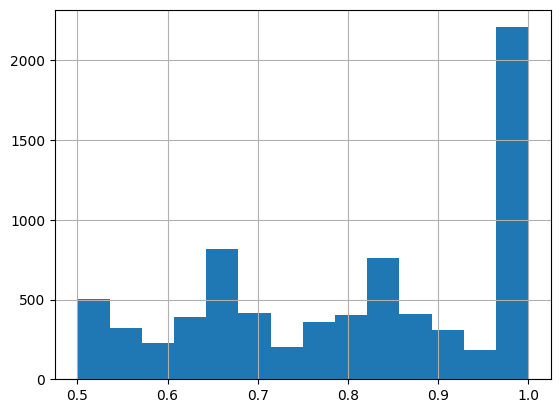

In [72]:
long_form.jaccard_similarity.hist(bins='sturges')


In [150]:
#score_distribution

### Drop multiple comparisons (duplicate target pairs)

In [309]:
similar_targets = long_form.drop_duplicates(subset=['target_1','target_2'])

### Group targets by adverse events

In [310]:
target_ae_grouped = target_ae_full_df.groupby('targetId')['event'].apply(list).reset_index(name='adverse_events')

In [314]:
#target_ae_grouped

In [312]:
train_target_ae_grouped = target_ae_grouped[~target_ae_grouped.targetId.isin(validation.targets)]

In [364]:
test_target_ae_grouped = target_ae_grouped[~target_ae_grouped.targetId.isin(test.targets)]

In [315]:
#train_target_ae_grouped

### KG results

In [126]:
path_102 = Path('C:/Users/ArulSeetharaman/Desktop/ADR_DrugSafety/Sai/drug similarity102export.csv')
path_10 = Path('C:/Users/ArulSeetharaman/Desktop/ADR_DrugSafety/Sai/drug similarity10export.csv')
df_102 = pd.read_csv(path_102)
df_10 = pd.read_csv(path_10)
df_102 = df_102[
        (df_102['Drug_1'] != df_102['Drug_2'])
].sort_values('jaccard_similarity',ascending = True)
df_102['jaccard_similarity'] = round(df_102['jaccard_similarity'],2)
drug_pairs = df_102.drop_duplicates(subset=['Drug_1','Drug_1','jaccard_similarity'])

### Merge similar targets with Adverse Events

In [365]:
similar_targets_ae = pd.merge(similar_targets,test_target_ae_grouped, left_on= 'target_1'  , right_on = 'targetId'  , how ='left')
similar_targets_ae = pd.merge(similar_targets_ae,test_target_ae_grouped, left_on= 'target_2'  , right_on = 'targetId'  , how ='left')



In [251]:
#similar_targets_ae

In [366]:
similar_targets_ae = similar_targets_ae[(similar_targets_ae.targetId_x.notna()) | (similar_targets_ae.targetId_y.notna())]

isna = similar_targets_ae['adverse_events_x'].isna()
similar_targets_ae.loc[isna,'adverse_events_x'] = pd.Series([[]] * isna.sum()).values

isnay = similar_targets_ae['adverse_events_y'].isna()
similar_targets_ae.loc[isnay,'adverse_events_y'] = pd.Series([[]] * isnay.sum()).values

### Find common AEs

In [367]:
similar_targets_ae['common_adverse_events'] = [list(set(a).intersection(set(b))) for a, b in zip(similar_targets_ae.adverse_events_x, similar_targets_ae.adverse_events_y)]

### Group Targets

In [368]:
similar_targets_ae['common_adverse_events'] = similar_targets_ae.common_adverse_events.astype("string").str.replace('[', '').str.replace(']', '').str.replace('"', '')

In [254]:
#similar_targets_ae[similar_targets_ae.common_adverse_events.str.len() > 0]

In [369]:
similar_targets_ae_grouped = similar_targets_ae.groupby('target_1')[['target_2','common_adverse_events']].agg(lambda x: list(x)).reset_index()

In [370]:
similar_targets_ae_grouped['common_adverse_events'] = similar_targets_ae_grouped.common_adverse_events.astype("string").str.replace('[', '').str.replace(']', '').str.replace('"', '')

### Remove Duplicate AEs

In [371]:
similar_targets_ae_grouped['unique_ae'] = similar_targets_ae_grouped['common_adverse_events'].apply(lambda x: set(x.split(',')))

In [372]:
similar_targets_ae_grouped = similar_targets_ae_grouped.drop('common_adverse_events',axis=1)

In [256]:
#similar_targets_ae_grouped

# Validation 

In [373]:
val_train_set = pd.concat([train,test])

In [197]:
#val_train_set

### Calculate similarity

In [374]:
val_one_hot_encoded = pd.get_dummies(val_train_set, columns= ["actionType","chemblIds","pathwayCategory","approvedIndications"])

val_one_hot_encoded = val_one_hot_encoded.groupby('targets').sum().clip(upper=1)

val_nd_array = val_one_hot_encoded.to_numpy()

val_jac_sim = 1 - pairwise_distances(val_nd_array, metric='jaccard',n_jobs =-2)

val_jac_sim_df = pd.DataFrame(val_jac_sim, index= val_one_hot_encoded.index, columns=val_one_hot_encoded.index)


c:\Users\ArulSeetharaman\Miniconda3\lib\site-packages\sklearn\metrics\pairwise.py:2025: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


### Find drugs similar to validation set

In [375]:
# move to long form
val_long_form = val_jac_sim_df.unstack()
# rename columns and turn into a dataframe
val_long_form.index.rename(['target_1', 'target_2'], inplace=True)
val_long_form = val_long_form.to_frame('jaccard_similarity').reset_index()

val_long_form = val_long_form[
    (long_form['jaccard_similarity'] >= 0.50) 
    & 
        (val_long_form['target_1'] != val_long_form['target_2'])
].sort_values('jaccard_similarity',ascending = True)

val_long_form['jaccard_similarity'] = round(val_long_form['jaccard_similarity'],2)

### Filter validation drugs

In [376]:
val_drug_pairs = val_long_form[val_long_form.target_1.isin(test.targets)]

### Validation Common AEs

In [377]:
filter_similar_targets_ae_grouped = similar_targets_ae_grouped[~similar_targets_ae_grouped.target_1.isin(test.targets)] # removing val targets

In [378]:
val_matched_drugs =  filter_similar_targets_ae_grouped[filter_similar_targets_ae_grouped.target_1.isin(val_drug_pairs.target_2)]

In [379]:
predicted_true_comparison_4 = pd.merge(val_matched_drugs,target_ae_grouped, left_on= 'target_1', right_on= 'targetId', how= 'inner')
predicted_true_comparison_4['unique_ae_array'] = [','.join(map(str, l)) for l in predicted_true_comparison_4['unique_ae']]
predicted_true_comparison_4['unique_ae_array'] = predicted_true_comparison_4.unique_ae_array.str.replace("'","").str.split(",")
predicted_true_comparison_4['unique_ae_array'] = predicted_true_comparison_4['unique_ae_array'].apply(lambda x: list(map(str.strip, x)))
predicted_true_comparison_4['unique_ae_array'] = predicted_true_comparison_4.unique_ae_array.astype("string")
predicted_true_comparison_4['unique_ae_array'] = predicted_true_comparison_4.unique_ae_array.str.replace('"',"").str.replace("'',","").str.replace("''",'')
predicted_true_comparison_4['adverse_events'] = predicted_true_comparison_4.adverse_events.astype("string")
predicted_true_comparison_4['common_predicted_actual'] = [list(set(a).intersection(set(b))) for a, b in zip(predicted_true_comparison_4.adverse_events.str.split(","), predicted_true_comparison_4.unique_ae_array.str.split(","))]
predicted_true_comparison_4['actual_count'] = predicted_true_comparison_4.adverse_events.str.split(",").str.len()
predicted_true_comparison_4['predicted_count'] = predicted_true_comparison_4.common_predicted_actual.str.len()
predicted_true_comparison_4 = predicted_true_comparison_4.drop('unique_ae', axis=1)
predicted_true_comparison_4['accuracy'] = round((predicted_true_comparison_4['predicted_count'] /predicted_true_comparison_4['actual_count']),2) 

In [382]:
predicted_true_comparison_4

target_1   
0   ENSG00000050555  \
1   ENSG00000065518   
2   ENSG00000070886   
3   ENSG00000088926   
4   ENSG00000092969   
..              ...   
76  ENSG00000206384   
77  ENSG00000211452   
78  ENSG00000211891   
79  ENSG00000213619   
80  ENSG00000244734   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           target_2   
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        [ENSG00000060718, ENSG00000196569, ENSG00000135862, ENSG00000196739, ENSG00000172037, ENSG00000101680, ENSG00000091136, ENSG00000058085, ENSG00000053747, ENSG00000130702]  \
1   [ENSG00000198840, ENSG00000198763, ENSG00000178057, ENSG00000119421, ENSG00000189043, ENSG00000164258, ENSG00000140990, ENSG00000174886, ENSG00000131495, ENSG00000099795, ENSG00000198786, ENSG00000184752, ENSG00000198886, ENSG00000166136, ENSG00000128609, ENSG00000151366, ENSG00000213619, ENSG00000136521, ENSG00000160194, ENSG00000115159, ENSG00000170906, ENSG00000184983, ENSG00000267855, ENSG00000198888, ENSG00000198695, ENSG00000186010, ENSG00000183648, ENSG00000130414, ENSG00000125356, ENSG00000119013, ENSG00000110717, ENSG00000109390, ENSG00000090266, ENSG00000004779, ENSG00000137806, ENSG00000178127, ENSG00000168653, ENSG00000167792, ENSG00000165264, ENSG00000164182, ENSG00000158864, ENSG00000147684, ENSG00000147123, ENSG00000145494, ENSG00000139180, ENSG00000123545, ENSG00000023228]   
2                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         [ENSG00000196411, ENSG00000146904, ENSG00000182580, ENSG00000044524, ENSG00000154928, ENSG00000133216, ENSG00000080224, ENSG00000116106, ENSG00000145242]   
3                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         

In [380]:
predicted_true_comparison_4.accuracy.mean()

0.671358024691358

In [381]:
predicted_true_comparison_4.to_csv("target_ae_test_accuracy.csv")    


In [165]:
predicted_true_comparison_5 = pd.merge(similar_drugs_ae_grouped[similar_drugs_ae_grouped.Drug_1.isin(fold_5.index)],adverse_events_grouped, left_on= 'Drug_1', right_on= 'chembl_id', how= 'inner')
predicted_true_comparison_5['unique_ae_array'] = [','.join(map(str, l)) for l in predicted_true_comparison_5['unique_ae']]
predicted_true_comparison_5['unique_ae_array'] = predicted_true_comparison_5.unique_ae_array.str.replace("'","").str.split(",")
predicted_true_comparison_5['unique_ae_array'] = predicted_true_comparison_5['unique_ae_array'].apply(lambda x: list(map(str.strip, x)))
predicted_true_comparison_5['unique_ae_array'] = predicted_true_comparison_5.unique_ae_array.astype("string")
predicted_true_comparison_5['adverse_events'] = predicted_true_comparison_5.adverse_events.astype("string")
predicted_true_comparison_5['common_predicted_actual'] = [list(set(a).intersection(set(b))) for a, b in zip(predicted_true_comparison_5.adverse_events.str.split(","), predicted_true_comparison_5.unique_ae_array.str.split(","))]
predicted_true_comparison_5['actual_count'] = predicted_true_comparison_5.adverse_events.str.split(",").str.len()
predicted_true_comparison_5['predicted_count'] = predicted_true_comparison_5.common_predicted_actual.astype("string").str.split(",").str.len()
predicted_true_comparison_5 = predicted_true_comparison_5.drop('unique_ae', axis=1)
predicted_true_comparison_5['accuracy'] = round((predicted_true_comparison_5['predicted_count'] /predicted_true_comparison_5['actual_count']),2) 

In [182]:
predicted_true_comparison_6 = pd.merge(similar_drugs_ae_grouped[similar_drugs_ae_grouped.Drug_1.isin(test_data.index)],adverse_events_grouped, left_on= 'Drug_1', right_on= 'chembl_id', how= 'inner')


In [183]:
predicted_true_comparison_6

Empty DataFrame
Columns: [Drug_1, Drug_2, unique_ae, chembl_id, adverse_events]
Index: []

In [ ]:
predicted_true_comparison_6['unique_ae_array'] = [','.join(map(str, l)) for l in predicted_true_comparison_6['unique_ae']]
predicted_true_comparison_6['unique_ae_array'] = predicted_true_comparison_6.unique_ae_array.str.replace("'","").str.split(",")
predicted_true_comparison_6['unique_ae_array'] = predicted_true_comparison_6['unique_ae_array'].apply(lambda x: list(map(str.strip, x)))
predicted_true_comparison_6['unique_ae_array'] = predicted_true_comparison_6.unique_ae_array.astype("string")
predicted_true_comparison_6['adverse_events'] = predicted_true_comparison_6.adverse_events.astype("string")
predicted_true_comparison_6['common_predicted_actual'] = [list(set(a).intersection(set(b))) for a, b in zip(predicted_true_comparison_6.adverse_events.str.split(","), predicted_true_comparison_6.unique_ae_array.str.split(","))]
predicted_true_comparison_6['actual_count'] = predicted_true_comparison_6.adverse_events.str.split(",").str.len()
predicted_true_comparison_6['predicted_count'] = predicted_true_comparison_6.common_predicted_actual.astype("string").str.split(",").str.len()
predicted_true_comparison_6 = predicted_true_comparison_6.drop('unique_ae', axis=1)
predicted_true_comparison_6['accuracy'] = round((predicted_true_comparison_6['predicted_count'] /predicted_true_comparison_6['actual_count']),2) 

## Prediction Results and Accuracy

In [167]:
predicted_true_comparison_1.accuracy.mean()


0.5628846153846154

In [172]:
predicted_true_comparison_2.accuracy.mean()


0.5371028037383176

In [173]:
predicted_true_comparison_3.accuracy.mean()


0.5529473684210525

In [228]:
predicted_true_comparison_4.accuracy.mean()


0.020424

In [175]:
predicted_true_comparison_5.accuracy.mean()

0.5496428571428572

In [181]:
predicted_true_comparison_6.accuracy.mean()

AttributeError: 'DataFrame' object has no attribute 'accuracy'

In [176]:
train_data

actionType_ACTIVATOR  actionType_AGONIST   
chemblIds                                                 
CHEMBL1201284                     0                   0  \
CHEMBL1201286                     0                   0   
CHEMBL1201287                     0                   0   
CHEMBL1201288                     0                   0   
CHEMBL1201293                     0                   0   
...                             ...                 ...   
CHEMBL995                         0                   0   
CHEMBL9967                        0                   0   
CHEMBL997                         0                   0   
CHEMBL998                         0                   0   
CHEMBL99946                       0                   0   

               actionType_ANTAGONIST  actionType_ANTISENSE INHIBITOR   
chemblIds                                                              
CHEMBL1201284                      0                               0  \
CHEMBL1201286                      1                               0   
CHEMBL1201287                      1                               0   
CHEMBL1201288                      1                               0   
CHEMBL1201293                      1                               0   
...                              ...                             ...   
CHEMBL995                          1                               0   
CHEMBL9967                         1                               0   
CHEMBL997                          0                               0   
CHEMBL998                          1                               0   
CHEMBL99946                        0                               0   

               actionType_BINDING AGENT  actionType_BLOCKER   
chemblIds                                                     
CHEMBL1201284                         0                   0  \
CHEMBL1201286                         0                   0   
CHEMBL1201287                         0                   0   
CHEMBL1201288                         0                   0   
CHEMBL1201293                         0                   0   
...                                 ...                 ...   
CHEMBL995                             0                   0   
CHEMBL9967                            0                   0   
CHEMBL997                             0                   0   
CHEMBL998                             0                   0   
CHEMBL99946                           0                   0   

               actionType_CROSS-LINKING AGENT  actionType_HYDROLYTIC ENZYME   
chemblIds                                                                     
CHEMBL1201284                               0                             0  \
CHEMBL1201286                               0                             0   
CHEMBL1201287                               0                             0   
CHEMBL1201288                               0                             0   
CHEMBL1201293                               0                             0   
...                                       ...                           ...   
CHEMBL995                                   0                             0   
CHEMBL9967                                  0                             0   
CHEMBL997                                   0                             0   
CHEMBL998                                   0                             0   
CHEMBL99946                                 0                             0   

               actionType_INHIBITOR  actionType_INVERSE AGONIST   
chemblIds                                                         
CHEMBL1201284                     0                           0  \
CHEMBL1201286                     0                           0   
CHEMBL1201287                     0                           0   
CHEMBL1201288                     0                           0   
CHEMBL1201293                     0                         

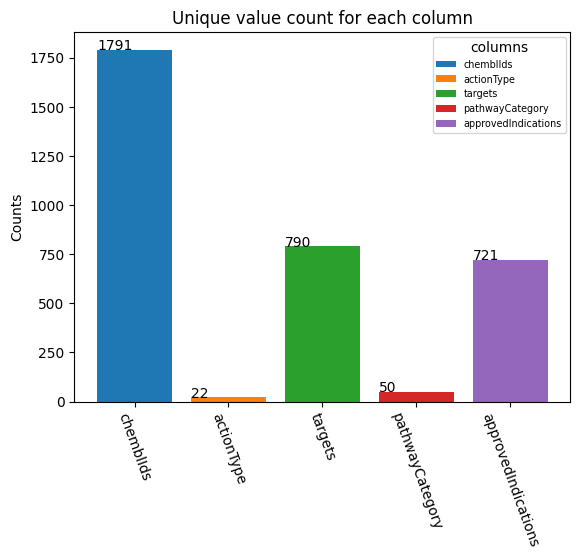

In [63]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

columns = clean_drug_targets_moa_pathway_indications.columns.tolist()
counts = clean_drug_targets_moa_pathway_indications.nunique().tolist()
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
          '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf','#0000EE','#FFEBCD','#E3CF57']
#bar_labels = ['red', 'blue', '_red', 'orange']
#bar_colors = ['tab:red', 'tab:blue', 'tab:red', 'tab:orange']

ax.bar(columns, counts, label=columns, color=colors)
xlocs, xlabs = plt.xticks()

ax.set_ylabel('Counts')
ax.set_title('Unique value count for each column')
ax.legend(title='columns',fontsize ='x-small')
ax.tick_params('x', labelrotation=290)

for i, v in enumerate(counts):
    plt.text(xlocs[i] - 0.40, v + 0.01, str(v))

plt.show()

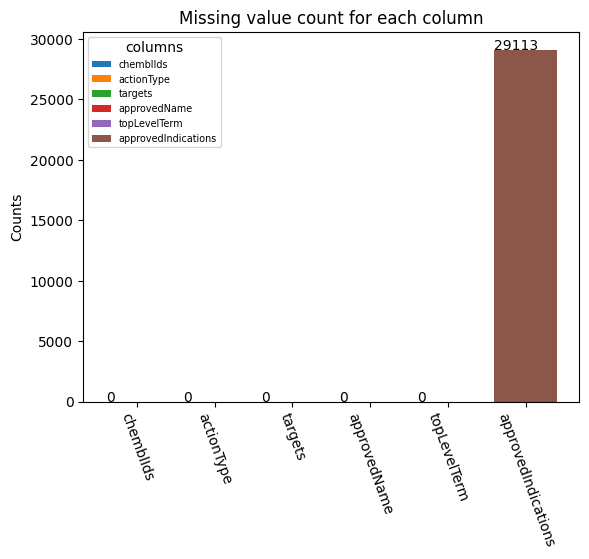

In [314]:
fig_missing, ax_missing = plt.subplots()

columns = clean_drug_targets_moa_pathway_indications.columns.tolist()
missing_count = clean_drug_targets_moa_pathway_indications.isna().sum().tolist()
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
          '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf','#0000EE','#FFEBCD','#E3CF57']
#bar_labels = ['red', 'blue', '_red', 'orange']
#bar_colors = ['tab:red', 'tab:blue', 'tab:red', 'tab:orange']

ax_missing.bar(columns, missing_count, label=columns, color=colors)
xlocs, xlabs = plt.xticks()
ax_missing.set_ylabel('Counts')
ax_missing.set_title('Missing value count for each column')
ax_missing.legend(title='columns',fontsize ='x-small')
ax_missing.tick_params('x', labelrotation=290)

for i, v in enumerate(missing_count):
    plt.text(xlocs[i] - 0.40, v + 0.01, str(v))

plt.show()

In [65]:
import scipy
from sklearn import preprocessing
label = preprocessing.LabelEncoder()
from scipy.stats import chi2_contingency
import numpy as np

In [63]:
ae_moa = pd.merge(ae_full_df,clean_drug_targets_moa_pathway_indications, left_on = 'chembl_id', right_on = 'chemblIds', how = 'inner')

ae_moa = ae_moa[['chembl_id','event','actionType','targets','pathwayCategory','approvedIndications']]

In [66]:
data_encoded = pd.DataFrame() 
for i in ae_moa.columns:
    data_encoded[i]=label.fit_transform(ae_moa[i])

In [67]:
def cramers_rule(var1,var2) :
    crosstab=pd.crosstab(index=var1, columns=var2)
    stat = scipy.stats.contingency.association(crosstab)
    return stat

rows=[]  
for var1 in ae_moa.columns.tolist(): 
    col=[]
    for var2 in ae_moa.columns.tolist(): 
        cramers =cramers_rule(ae_moa[var1], ae_moa[var2])
        col.append(round(cramers,2))
    rows.append(col)
cramers_results = np.array(rows) 
craemrs_correlation = pd.DataFrame(cramers_results,columns = data_encoded.columns, index=data_encoded.columns)

In [68]:
craemrs_correlation.style.background_gradient(cmap='YlGnBu')